# New remeshing ->  AvaKot Problem?

## Problem: 

When trying com8, it became clear that *both* our remeshing (legacy and rasterio) include the -9999 values in the remeshing, leading to overshooting and wrong nodata_values. See profile plot below. 

## Findings
- Happens with tif and asc
- Does not happen on fully defined DEMS (no nodata_values)
- Happens on all gridsize diffs (5 -> 5.1, 5->8, 5->2)

It seems to be a problem with the 
print(src.nodata) in the remeshDataRio. This returns -9999.0 and therefore does not match the -9999 in the file and includes this as data. 
Setting     src_nodata=-9999 in the rasterio.warp.reproject solves this!
So rasterio reads -9999 as -9999.0 (see rasterUtils getHeaderFromRaster)! This leads to problems...

## Solutions
- Cut all values below 0 after remeshing, but that does not remedy the problem right at the corners (see below in profile plot)
- Additionally check diff between neighbours and throw out big ones
- THIS IS THE ONE: consistently find out the nodata setting for warp.reproject


In [1]:
import rasterio
import shutil
import rasterio.plot
import rasterio.warp
from rasterio.crs import CRS
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import avaframe.in3Utils.fileHandlerUtils as fU
import avaframe.in2Trans.rasterUtils as IOf
import subprocess
import configparser
import avaframe.in2Trans.rasterUtils as rU
%load_ext autoreload
%autoreload 2
import avaframe.in3Utils.geoTrans as geoTrans

In [2]:
def getXCoords(src,data):

    height, width = data.shape #Find the height and width of the array

    #Two arrays with the same shape as the input array/raster, where each value is the x or y index of that cell
    cols, rows = np.meshgrid(np.arange(width), np.arange(height)) 

    #Two arrays with the same shape as the input array/raster, where each value is the x or y coordinate of that cell 
    xs, ys = rasterio.transform.xy(src.transform, rows, cols) 

    #They are actually lists, convert them to arrays
    xcoords = np.array(xs[0])
    ycoords = np.array(ys)

    return xcoords

# Get DEM

In [3]:
avaDir = pathlib.Path('./RTest')
demToRemesh = '/home/felix/Versioning/AvaFrame/avaframe/data/avaKot/Inputs/avaKot.asc'
#demToRemesh = '/home/felix/Versioning/AvaFrame/avaframe/data/avaAlr/Inputs/avaAlr.tif'
avaDEM = avaDir / "Inputs" / "avaKot.asc"
#avaDEM = avaDir / "Inputs" / "avaAlr.tif"
shutil.copy(demToRemesh, avaDEM)
subprocess.run(["head", "-n7", avaDEM])

ncols        439
nrows        517
xllcorner    176973.437998359208
yllcorner    376237.836376162944
cellsize     4.997688906601
NODATA_value  -9999
 -9999.0 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -99

CompletedProcess(args=['head', '-n7', PosixPath('RTest/Inputs/avaKot.asc')], returncode=0)

99 -9999 -9999 -9999 -9999 -9999 -9999 -9999


## Remesh

In [8]:
cfg = configparser.ConfigParser()
cfg["GENERAL"] = {
    "meshCellSizeThreshold": "0.0001",
    "meshCellSize": 5,
    "avalancheDir": str(avaDir),
}

pathDemRIO = geoTrans.remeshRaster(avaDEM, cfg, legacy=False)
# pathDemLegacy = geoTrans.remeshRaster(avaDEM, cfg, legacy=True)
fullPRIO = avaDir / "Inputs" / pathDemRIO
# fullPLegacy = avaDir / "Inputs" / pathDemLegacy
#print(fullPRIO, fullPLegacy)
dataRIO = IOf.readRaster(fullPRIO)
#dataLegacy = IOf.readRaster(fullPLegacy)
print(dataRIO["header"])
subprocess.run(["head", "-n7", fullPRIO])
#subprocess.run(["head", "-n7", avaDEM])
#subprocess.run(["head", "-n7", fullPLegacy])

{'ncols': 438, 'nrows': 516, 'cellsize': 5.0, 'xllcenter': 176975.93684281252, 'yllcenter': 376240.33522061625, 'nodata_value': nan, 'crs': None, 'driver': 'AAIGrid', 'transform': Affine(5.0, 0.0, 176973.43684281252,
       0.0, -5.0, 378817.83522061625)}
ncols        438
nrows        516
xllcorner    176973.436842812516
yllcorner    376237.835220616253
cellsize     5.000000000000
NODATA_value nan
nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan

CompletedProcess(args=['head', '-n7', PosixPath('RTest/Inputs/remeshedRasters/avaKot_remeshedDEM5.00.asc')], returncode=0)

## Plotting

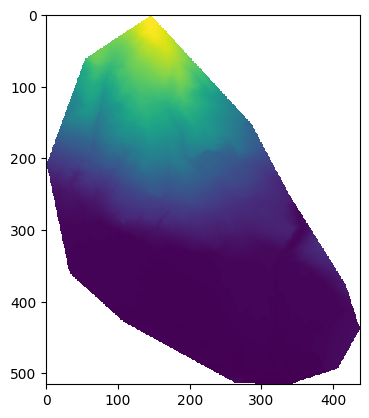

<Axes: >

In [5]:
rasterio.plot.show(dataRIO['rasterData'])
#rasterio.plot.show(dataLegacy['rasterData'])

In [11]:
srcRIO = rasterio.open(fullPRIO, 'r')
#srcLegacy = rasterio.open(fullPLegacy, 'r')
srcOrig = rasterio.open(avaDEM, 'r')
dataRIO = srcRIO.read(1)

#dataLegacy = srcLegacy.read(1)
dataOrig = srcOrig.read(1)
#dataNewRemesh = np.where(dataNewRemesh == srcNewRemesh.nodata, np.nan, dataNewRemesh)
xRIO = getXCoords(srcRIO,dataRIO)
#xLegacy = getXCoords(srcLegacy,dataLegacy)
xOrig = getXCoords(srcOrig,dataOrig)

print(xRIO)

# Plot the GeoTIFF
#fig, ax = plt.subplots(figsize=(10, 10))
#ax.set_title("RIO")
#axNew.set_xlim([-5, 20])
#axNew.set_ylim([-5, 25])
#axNew.hlines([-2.5,22.5],-5,20)
#axNew.vlines([-2.5,17.5],-5,25)

#ax.grid()

#rasterio.plot.show(dataRIO, transform=srcRIO.transform, ax=ax, alpha=1, cmap="viridis", zorder=5)


176975.93684281252


ValueError: x and y must have same first dimension, but have shapes (1,) and (438,)

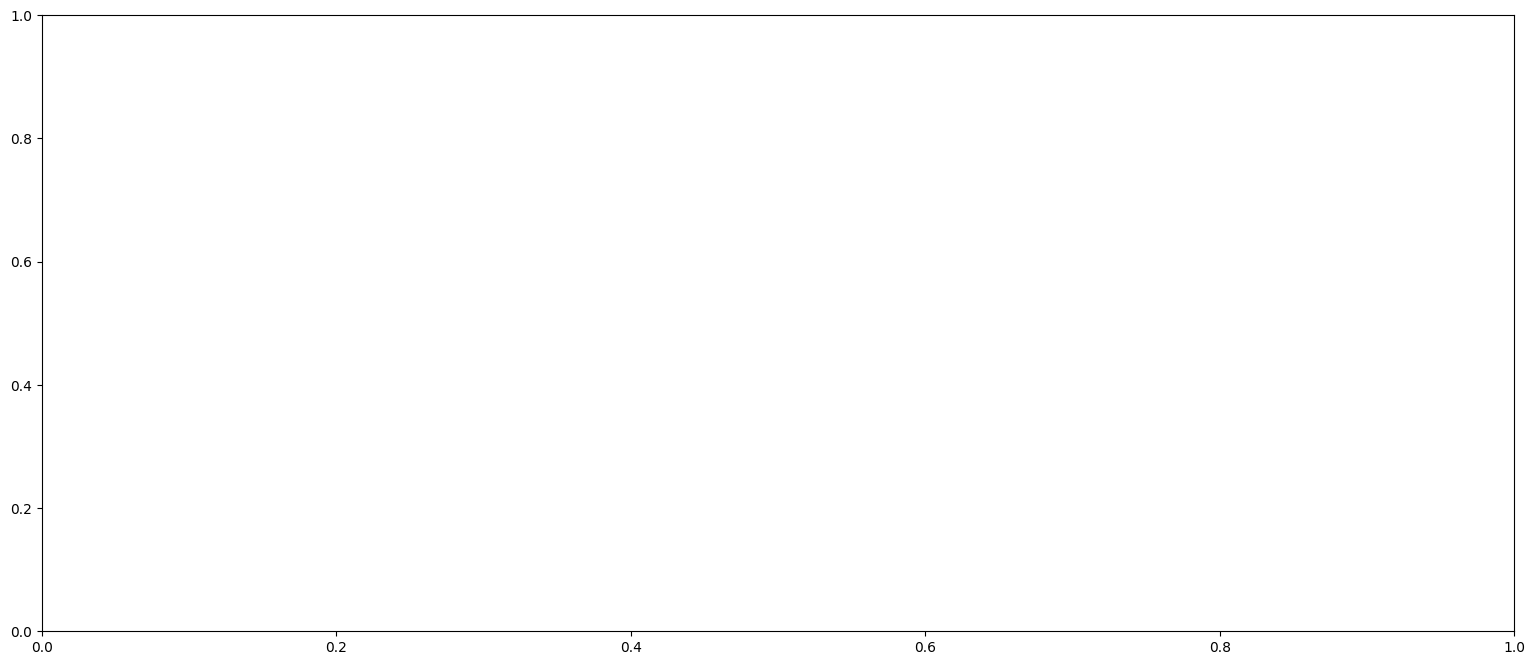

In [10]:
fig2, ax2 = plt.subplots(figsize=(19,8))
profRIO = dataRIO[5,:]
profOrig = dataOrig[5,:]
#profLegacy = dataLegacy[50,:]
#ax2.set_xlim([900,1100])
plt.plot(xRIO,profRIO,'-X',label='RIO')
#plt.plot(xLegacy,profLegacy,'-',label='Legacy')
plt.plot(xOrig,profOrig,'-',label='Orig')
ax2.legend()

In [ ]:
fig2, ax2 = plt.subplots(figsize=(19,8))
plt.plot(xRIO,profRIO - profLegacy,'-',label='RIO - Legacy')
ax2.legend()